# Manifold Learning

Manifold learning—a class of unsupervised estimators that seeks to describe datasets as low-dimensional manifolds embedded in high-dimensional spaces. 

A manifold is like a piece of paper - a 2D object in a 3D world that can be bent or rolled. (contorting it to fit 3D space)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

Now, we will create some data. The output is two dimensional, and consists of points drawn in the shape of the word, "HELLO".

In [2]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

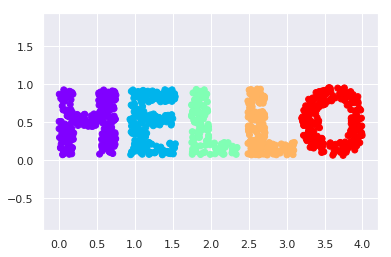

In [3]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

### Multidimensional Scaling (MDS)

If we rotate the data, the x and y values change, but the data is still fundamentally the same. This tells us that the x and y values are not necessarily fundamental to the relationships in the data. 



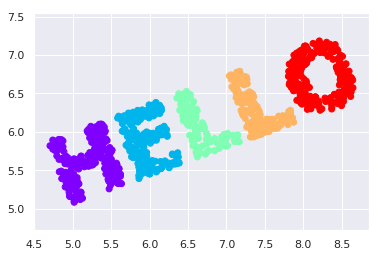

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

**What is fundamental**, in this case, is the distance between each point and the other points in the dataset. A common way to represent this is to use a distance matrix. We can use sklearn's `pairwise_distances` to do this. 

In [5]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

For our data with 1000 points, we obtain a 1000 X 1000 matrix containing distances for each data point to another. 

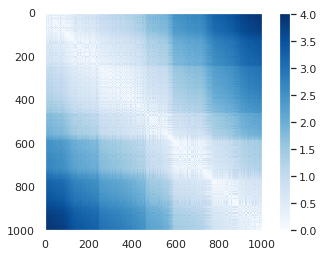

In [6]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

If we construct a distance matrix for out rotated and transformed data, we see that it is the same

In [7]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

#### What the MDS algorithm does

Given a distance matrix between points, the algorithm recovers an N dimensional representation of the data. 

We use the `precomputed` dissimilarity to specify that we are passing a distance matrix:

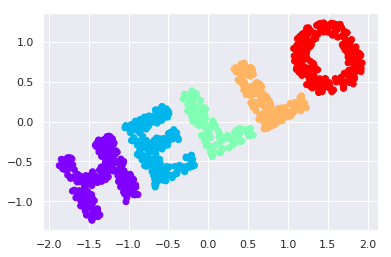

In [9]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

The MDS algorithm recovers one of the possible two-dimensional coordinate representations of our data, as shown above. 

#### Projecting data to 3 Dimensions

In [10]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

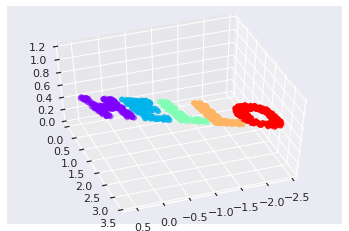

In [11]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

We can now ask the MDS estimator to input this three-dimensional data, compute the distance matrix, and then determine the optimal two-dimensional embedding for this distance matrix. The result recovers a representation of the original data:

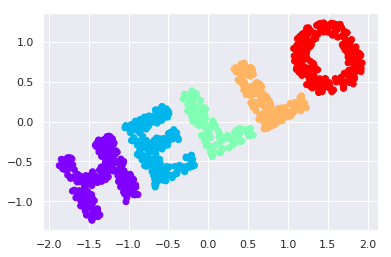

In [12]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

#### The goal of a manifold learning estimator: 

given high-dimensional embedded data, it seeks a low-dimensional representation of the data that preserves certain relationships within the data. In the case of MDS, the quantity preserved is the distance between every pair of points.

### Nonlinear embeddings: Where MDS fails

Consider the following embedding, which takes the input and contorts it into an "S" shape in three dimensions:

In [14]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

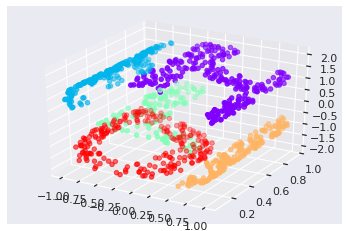

In [15]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

The fundamental relationships between the data points are still there, but this time the data has been transformed in a nonlinear way: it has been wrapped-up into the shape of an "S."

If we try a simple MDS algorithm on this data, it is not able to "unwrap" this nonlinear embedding, and we lose track of the fundamental relationships in the embedded manifold:

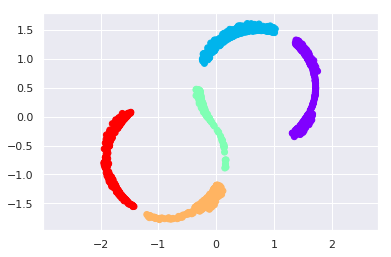

In [16]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

The best two-dimensional linear embeding does not unwrap the S-curve, but instead throws out the original y-axis.

### Locally Linear Embedding (LLE)

The source of the problem is that MDS tries to preserve distances between faraway points when constructing the embedding. 

LLE modifies the algorithm such that it only preserves distances between nearby points. We can see the difference in the visualization below. 

In [17]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as png
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

In [18]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

X = make_hello(1000)
XS = make_hello_s_curve(X)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))

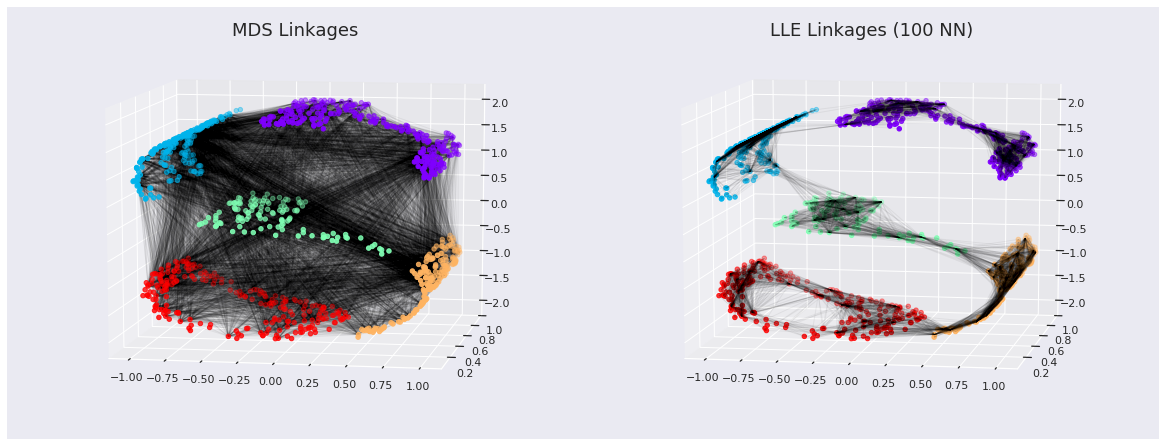

In [20]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from sklearn.neighbors import NearestNeighbors

# construct lines for MDS
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
lines_MDS = [(XS[i], XS[j]) for i in ind[:100] for j in ind[100:200]]

# construct lines for LLE
nbrs = NearestNeighbors(n_neighbors=100).fit(XS).kneighbors(XS[ind[:100]])[1]
lines_LLE = [(XS[ind[i]], XS[j]) for i in range(100) for j in nbrs[i]]
titles = ['MDS Linkages', 'LLE Linkages (100 NN)']

# plot the results
fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(projection='3d'))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)

for axi, title, lines in zip(ax, titles, [lines_MDS, lines_LLE]):
    axi.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize);
    axi.add_collection(Line3DCollection(lines, lw=1, color='black',
                                        alpha=0.05))
    axi.view_init(elev=10, azim=-80)
    axi.set_title(title, size=18)


Here each faint line represents a distance that should be preserved in the embedding. 

On the left is a representation of the model used by MDS: it tries to preserve the distances between each pair of points in the dataset. 

On the right is a representation of the model used by a manifold learning algorithm called locally linear embedding (LLE): rather than preserving all distances, it instead tries to preserve only the distances between neighboring points: in this case, the nearest 100 neighbors of each point.



Thinking about the left panel, we can see why MDS fails: there is no way to flatten this data while adequately preserving the length of every line drawn between the two points. For the right panel, on the other hand, things look a bit more optimistic. We could imagine unrolling the data in a way that keeps the lengths of the lines approximately the same. This is precisely what LLE does, through a global optimization of a cost function reflecting this logic.

Returning to the original example, we can see that LLE does a good job of recovering data with little distortion. 

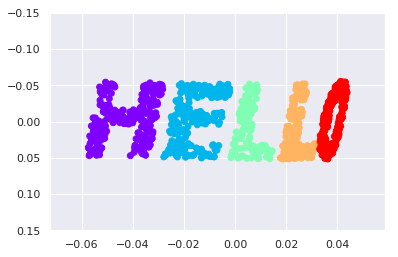

In [21]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

### Challenges of Manifold Learning

- no good framework for handling missing data
- the presence of noise in the data can "short-circuit" the manifold and drastically change the embedding
- highly dependent on the number of neighbors chosen
- globally optimal number of output dimensions is difficult to determine
- the meaning of the embedded dimensions is not always clear
- computationally expensive, O(N^2) or O(N^3) runtime

**The only clear advantage of manifold learning methods over PCA is their ability to preserve nonlinear relationships in the data**

### Sklearn implementations

- For non-linear problems, LLE perform well. Use `sklearn.manifold.LocallyLinearEmbedding`
- For high dimensional data from real world sources, Isomap generally leads to more meaningful embeddings. `sklearn.manifold.Isomap`
- For data that is highly clustered, t-distributed stochastic neighbor embedding (t-SNE) seems to work very well, though can be very slow compared to other methods. `sklearn.manifold.TSNE`

### Example: Isomap on Faces

A common use case of manifold learning is understanding the relationship between high dimensional data points. 

A common case of high-dimensional data is images: for example, a set of images with 1,000 pixels each can be thought of as a collection of points in 1,000 dimensions 

Here, we will apply Isomap on faces data. 

In [22]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

We have 2,370 images, each with 2,914 pixels

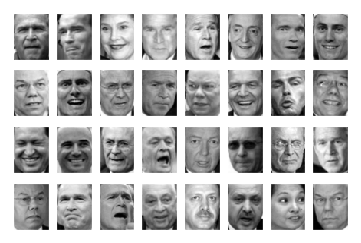

In [23]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

Use PCA to examine the explained variance ratio

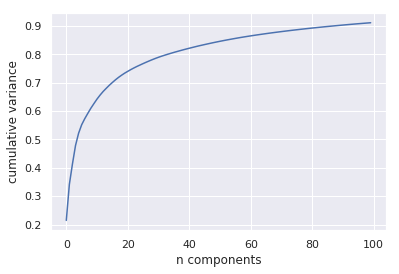

In [25]:
from sklearn.decomposition import PCA
model = PCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

Approximately 100 components are required to preserve 90% of the variance. 

In [26]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

The output is a 2 dimensional projection of all of the input images. Let us output the image at the locations (xy coordinates) of the projection

In [27]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

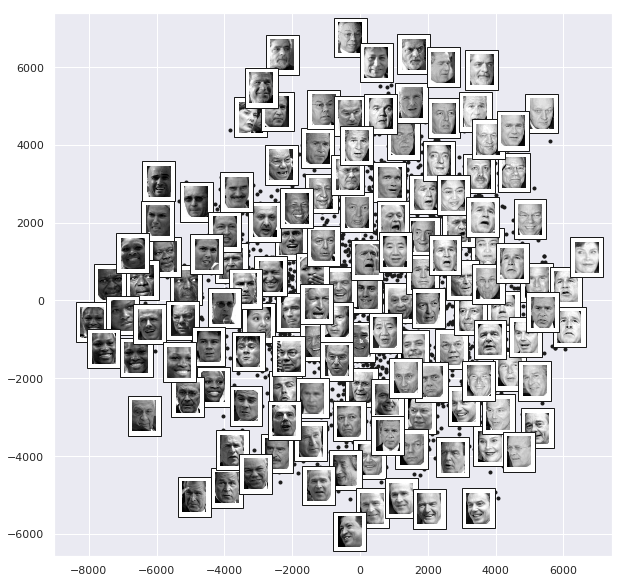

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

We can see that the x-axis seems to describe the overall brightness of the image from left (dark) to right (bright)

The y axis describes the orientation of the faces from top (right-facing) to bottom (left-facing)